# Test set scores for stocks with 10000 data points

In this notebook we present results for stocks with 10000 data points on test set for the choosen SVM models.

In [1]:
%matplotlib inline
import pandas as pd
import requests
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt

from lob_data_utils import roc_results
from lob_data_utils import lob
from lob_data_utils import db_result

data_length = 10000

## Data preparation

Data frame `df_cv` contains parameters and results from svm calculations for data length 10000 on validation set:

* `c` - C parameter for svm kernel - it's used by ****linear****, ****rbf**** and ****sigmoid**** kernels
* `gamma` - $\gamma$ parameter for svm kernel - it's used by ****rbf**** and ****sigmoid**** kernels, for **linear** it's set to $-1$.
* `coef0` - coef0 parameter for ****sigmoid**** kernel only - for other kernels it's set to -1.
* `kernel` - kernel name
* `stock` - stock_id
* `roc_auc_score` - area under ROC curve for calculation using `kernel`, `c`, `gamma` and `coef0` for stock `stock` on validation data from 10000 data point data set
* `log_res` - result for logistic regression for 10000 data points
* `log_diff` - difference between `roc_auc_score` and `log_res`

In [2]:
results = db_result.get_svm_results_for_data_length(data_length, 'test')
result_cv = db_result.get_svm_results_for_data_length(data_length, 'cv')

df_cv = pd.DataFrame(result_cv)

In [3]:
df_cv.drop('algorithm_id', axis=1, inplace=True)
df_cv.drop('svm_id', axis=1, inplace=True)
df_cv.drop('name', axis=1, inplace=True)
df_cv.drop('id', axis=1, inplace=True)
df_cv.drop('data_length', axis=1, inplace=True)
df_cv.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock
0,0.0005,0.0000,cv,0.0050,sigmoid,0.5,10166
1,0.0005,0.0000,cv,0.0005,sigmoid,0.5,10166
2,0.0005,0.0005,cv,0.0005,sigmoid,0.5,10166
3,0.0005,0.0050,cv,0.0005,sigmoid,0.5,10166
4,0.0005,0.5000,cv,0.0005,sigmoid,0.5,10166


#### Description of `df_bests`

In this data set we aggregate calculations with the best score by stock. It has the same fields as `df_cv`.

* `c` - C parameter for svm kernel - it's used by ****linear****, ****rbf**** and ****sigmoid**** kernels
* `gamma` - $\gamma$ parameter for svm kernel - it's used by ****rbf**** and ****sigmoid**** kernels, for **linear** it's set to $-1$
* `coef0` - coef0 parameter for ****sigmoid**** kernel only - for other kernels it's set to -1
* `kernel` - kernel name
* `stock` - stock_id
* `roc_auc_score` - area under ROC curve for calculation using `kernel`, `c`, `gamma` and `coef0` for stock `stock` on validation data from 10000 points dataset
* `log_res` - result for logistic regression for data with 10000 data points
* `log_diff` - difference between `roc_auc_score` and `log_res`

Additionally it has:

* `test_roc_auc_score` - roc area score for test set for the parameters `C`, `gamma` and `coef0` and `kernel`
* `test_log_roc_auc_score` - roc area score for test set for logistic regression

In [4]:
bests = []
df_best_agg = df_cv.groupby('stock', as_index=False)['roc_auc_score'].idxmax()
df_bests = df_cv.loc[df_best_agg]
df_bests.index = df_bests['stock']

test_roc_auc_scores = []
for i, row in df_bests.iterrows():
    res = db_result.get_svm_results_by_params(
            row['stock'], row['kernel'], data_type='test', data_length=data_length, 
            gamma=row['gamma'], c=row['c'], coef0=row['coef0'])
    test_roc_auc_scores.append(res[0].get('roc_auc_score'))

df_bests['test_roc_auc_score'] = test_roc_auc_scores 

In [5]:
log_res = []
for i, row in df_bests.iterrows():
    log_res.append(roc_results.result_test_10000.get(row['stock']))
df_bests['test_log_roc_auc_score'] = log_res
df_bests['diff'] = df_bests['test_roc_auc_score'] - log_res
df_bests.sort_values(by='roc_auc_score', inplace=True)
df_bests.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score,test_log_roc_auc_score,diff
stock,,,,,,,,,,
9062,100.000,0.0,cv,0.001,rbf,0.537639,9062,0.546644,0.552745,-0.006101
9069,500.000,0.0,cv,0.005,rbf,0.544390,9069,0.530195,0.546371,-0.016176
4618,0.005,0.0,cv,500.000,sigmoid,0.548025,4618,0.548702,0.549917,-0.001215
9064,500.000,0.0,cv,50.000,rbf,0.550204,9064,0.537237,0.532707,0.004531
11244,10.000,0.0,cv,100.000,rbf,0.551674,11244,0.542109,0.545852,-0.003744


## Results for testing set

Below we present results comparing the best performing SVM on validation set against null hyposthesis and then to previous solution - logistic regression on testing set.

### SVM vs null hypothesis and validation set score

We compare best performing SVM models on validation set against null hypothesis using ROC area scores calculated on testing set.

We are always better than null-hypothesis - between 2-7%.

We can see that in most cases we perform worse on testing set than on validation set. The difference can be even 2%.

Testing - min:  0.521385368664 max: 0.600878076046
Validation - min:  0.537639217381 max: 0.593960104045


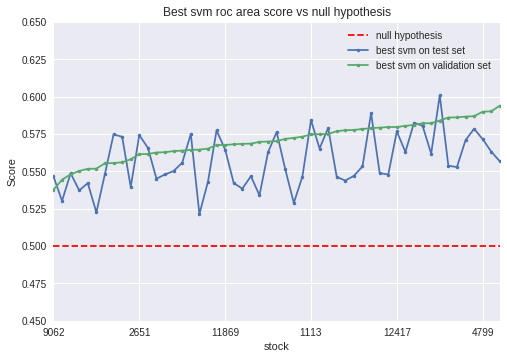

In [6]:
stocks = df_bests['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests['test_roc_auc_score'].plot(marker='.', label='best svm on test set')
df_bests['roc_auc_score'].plot(marker='.', label='best svm on validation set')
print('Testing - min: ', df_bests['test_roc_auc_score'].min(), 'max:',  df_bests['test_roc_auc_score'].max())
print('Validation - min: ', df_bests['roc_auc_score'].min(), 'max:',  df_bests['roc_auc_score'].max())
plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best svm roc area score vs null hypothesis')

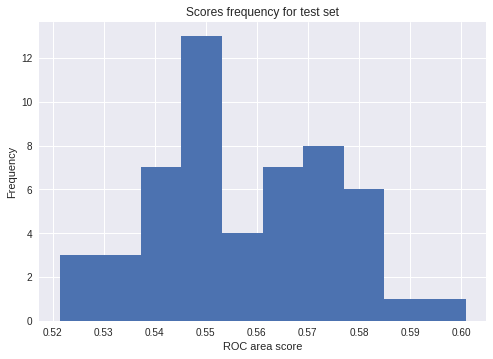

In [7]:
df_bests['test_roc_auc_score'].plot('hist')
plt.title('Scores frequency for test set')
plt.xlabel('ROC area score')

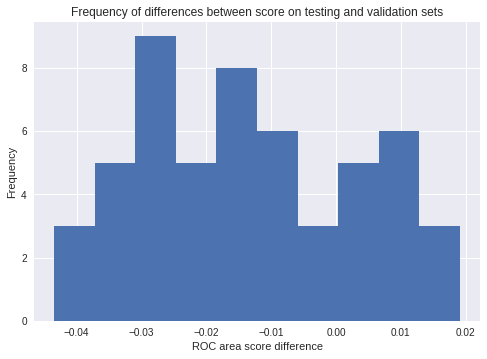

In [8]:
(df_bests['test_roc_auc_score'] - df_bests['roc_auc_score']).plot(kind='hist')
plt.title('Frequency of differences between score on testing and validation sets')
plt.xlabel('ROC area score difference')

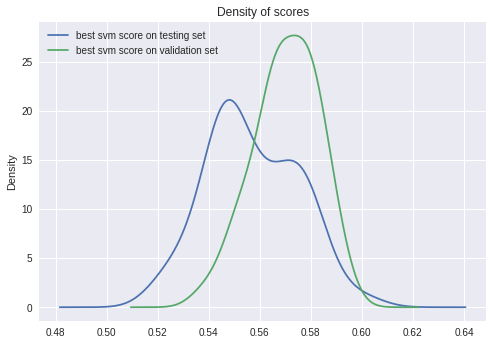

In [9]:
df_bests['test_roc_auc_score'].plot('kde', label='best svm score on testing set')
df_bests['roc_auc_score'].plot('kde', label='best svm score on validation set')
plt.title('Density of scores')
plt.legend()

### SVM vs logistic regression on testing set

In half of the cases we perform better than logistic regression. The difference varies between -1.25% and 0.3%.

In [10]:
print('Number of better SVMs:', 
      len(df_bests[df_bests['test_log_roc_auc_score'] < df_bests['test_roc_auc_score']]['stock'].unique()), 
      'per', len(df_bests['stock'].unique()))

Number of better SVMs: 22 per 53


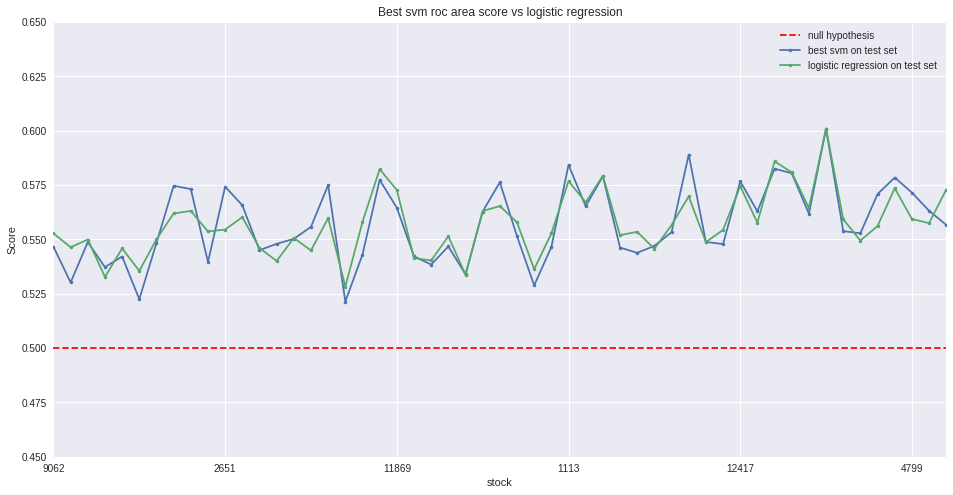

In [11]:
stocks = df_bests['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests['test_roc_auc_score'].plot(marker='.', label='best svm on test set', figsize=(16, 8))
df_bests['test_log_roc_auc_score'].plot(marker='.', label='logistic regression on test set')

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best svm roc area score vs logistic regression')

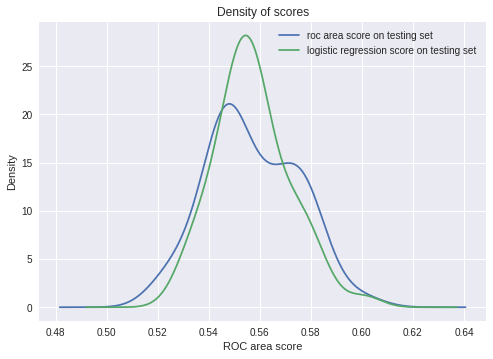

In [12]:
df_bests['test_roc_auc_score'].plot('kde', label='roc area score on testing set')
df_bests['test_log_roc_auc_score'].plot('kde', label='logistic regression score on testing set')
plt.title('Density of scores')
plt.xlabel('ROC area score')
plt.legend()

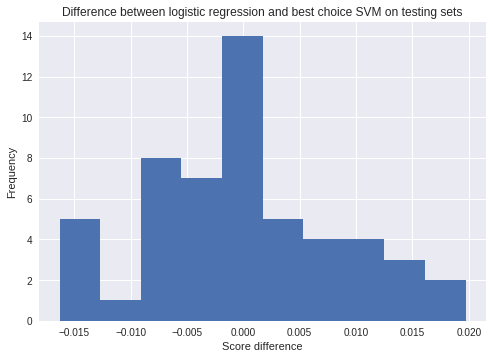

In [13]:
df_bests['diff'].plot(kind='hist')
plt.title('Difference between logistic regression and best choice SVM on testing sets')
plt.xlabel('Score difference')

## Results for testing by kernel

We choose the best performing model with linear, rbf and sigmoid kernel for each stock and compare them with null-hypothesis and logistic regression. 

We also compare how well they generalize using the scores from the same models on validation set.

To present results by kernel we prepare data frames:
* `df_bests_by_kernels` - aggregated results by kernel 
* `df_kernels_test` - `test_roc_auc_score` results (for testing set) for each stock
* `df_kernels_cv` - `test_roc_auc_score` results (for validation set) for each stock
* `df_bests_by_test` - model parameters for models which give the best result on testing set 
* `df_bests_by_val`- model parameters for models which give the best result on validations set.

In [14]:
df_best_agg = df_cv.groupby(['stock', 'kernel'], as_index=False)['roc_auc_score'].idxmax()
df_bests_by_kernels = df_cv.loc[df_best_agg]

test_roc_auc_scores = []
for i, row in df_bests_by_kernels.iterrows():
    res = db_result.get_svm_results_by_params(
            row['stock'], row['kernel'], data_type='test', data_length=data_length, 
            gamma=row['gamma'], c=row['c'], coef0=row['coef0'])
    test_roc_auc_scores.append(res[0].get('roc_auc_score'))

df_bests_by_kernels['test_roc_auc_score'] = test_roc_auc_scores 

In [15]:
log_res = []
for i, row in df_bests_by_kernels.iterrows():
    log_res.append(roc_results.result_test_10000.get(row['stock']))
df_bests_by_kernels['test_log_roc_auc_score'] = log_res
df_bests_by_kernels['diff'] = df_bests_by_kernels['test_roc_auc_score'] - log_res
df_bests_by_kernels.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score,test_log_roc_auc_score,diff
146,0.500,0.0,cv,-1.0,linear,0.559372,10166,0.550122,0.546020,0.004102
31947,500.000,0.0,cv,100.0,rbf,0.562580,10166,0.545034,0.546020,-0.000986
93,0.005,5.0,cv,500.0,sigmoid,0.560516,10166,0.548460,0.546020,0.002440
10975,0.005,0.0,cv,-1.0,linear,0.551864,10484,0.556484,0.553632,0.002852
11007,0.500,0.0,cv,5.0,rbf,0.554403,10484,0.555391,0.553632,0.001759


In [16]:
bests = []
df_best_agg = df_bests_by_kernels.groupby('stock', as_index=False)['test_roc_auc_score'].idxmax()
df_bests_by_test = df_bests_by_kernels.loc[df_best_agg]
df_bests_by_test.sort_index(inplace=True)
df_bests_by_test.index = df_bests_by_test['stock']

bests = []
df_best_agg = df_bests_by_kernels.groupby('stock', as_index=False)['roc_auc_score'].idxmax()
df_bests_by_val = df_bests_by_kernels.loc[df_best_agg]
df_bests_by_val.index = df_bests_by_val['stock']
df_bests_by_val.sort_index(inplace=True)
df_bests_by_val.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score,test_log_roc_auc_score,diff
stock,,,,,,,,,,
10166,500.000,0.0000,cv,100.000,rbf,0.562580,10166,0.545034,0.546020,-0.000986
10484,0.500,0.0005,cv,0.500,sigmoid,0.558058,10484,0.539602,0.553632,-0.014030
10508,0.005,0.0000,cv,5.000,sigmoid,0.574945,10508,0.579002,0.579272,-0.000271
10887,50.000,5.0000,cv,0.500,sigmoid,0.568068,10887,0.542179,0.541398,0.000781
1113,500.000,0.0000,cv,0.005,rbf,0.574734,1113,0.584238,0.576817,0.007422


In [17]:
df_kernels_test = df_bests_by_kernels.pivot(index='stock', columns='kernel', values='test_roc_auc_score')
df_kernels_test.sort_index(inplace=True)
df_kernels_test.head()

df_kernels_val = df_bests_by_kernels.pivot(index='stock', columns='kernel', values='roc_auc_score')
df_kernels_val.sort_index(inplace=True)
df_kernels_val.head()

kernel,linear,rbf,sigmoid
stock,,,
10166,0.559372,0.562580,0.560516
10484,0.551864,0.554403,0.558058
10508,0.573052,0.574304,0.574945
10887,0.566705,0.567645,0.568068
1113,0.563114,0.574734,0.573896


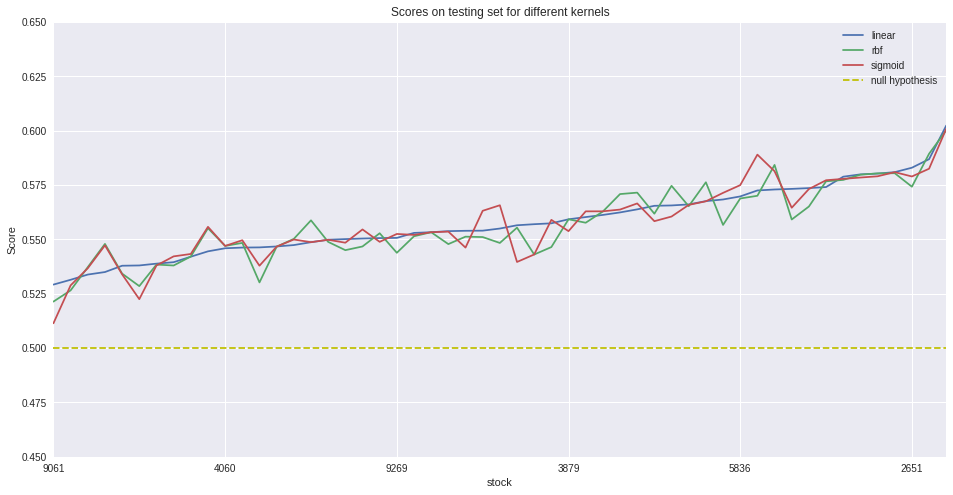

In [18]:
df_kernels_test.sort_values(by=['linear', 'sigmoid', 'rbf']).plot(figsize=(16, 8))
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')
plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Scores on testing set for different kernels')

There are less differences between kernels on testing set. We will check them separately in next sections.

### Linear kernel

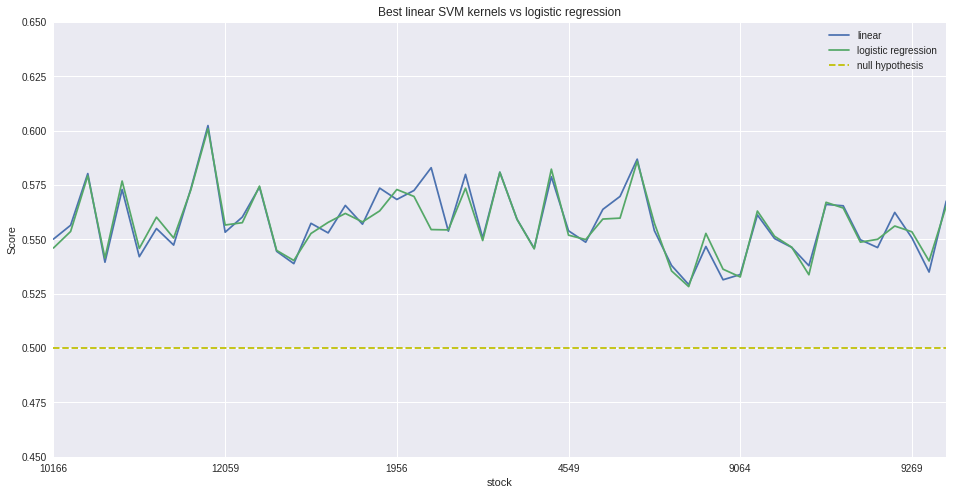

In [19]:
df_bests.sort_index(inplace=True)
df_kernels_test['linear'].plot(figsize=(16,8))
df_bests['test_log_roc_auc_score'].plot(label='logistic regression')
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best linear SVM kernels vs logistic regression')

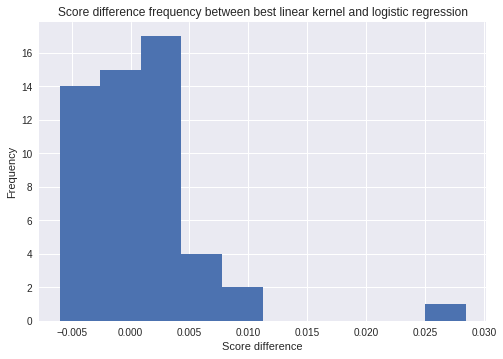

In [20]:
(df_kernels_test['linear'] - df_bests['test_log_roc_auc_score']).plot(kind='hist')
plt.xlabel('Score difference')
plt.title('Score difference frequency between best linear kernel and logistic regression')

#### RBF TODO


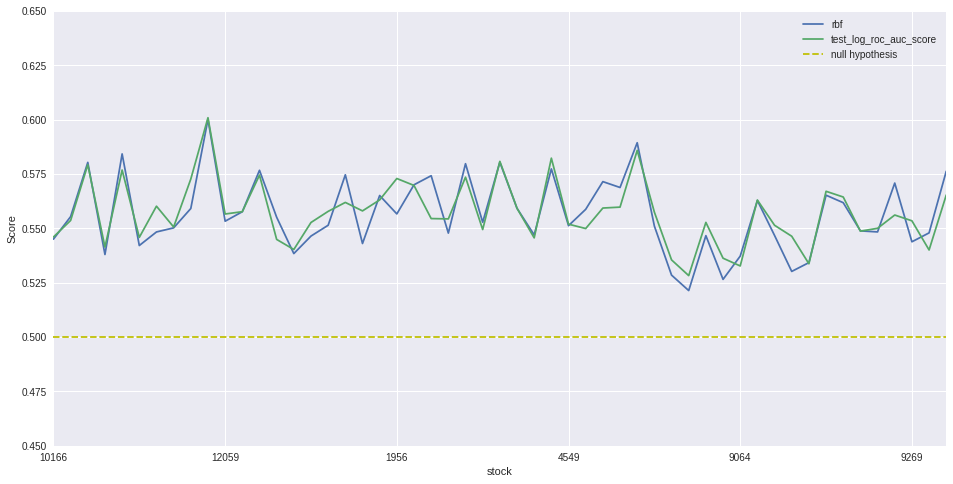

In [21]:
df_bests.sort_index(inplace=True)
df_kernels_test['rbf'].plot(figsize=(16,8))
df_bests['test_log_roc_auc_score'].plot()
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('')

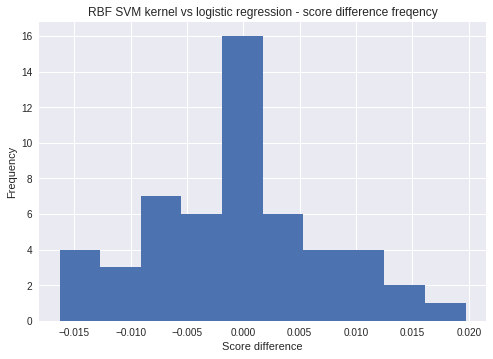

In [22]:
(df_kernels_test['rbf'] - df_bests['test_log_roc_auc_score']).plot(kind='hist')
plt.xlabel('Score difference')
plt.title('RBF SVM kernel vs logistic regression - score difference freqency')

#### Sigmoid TODO

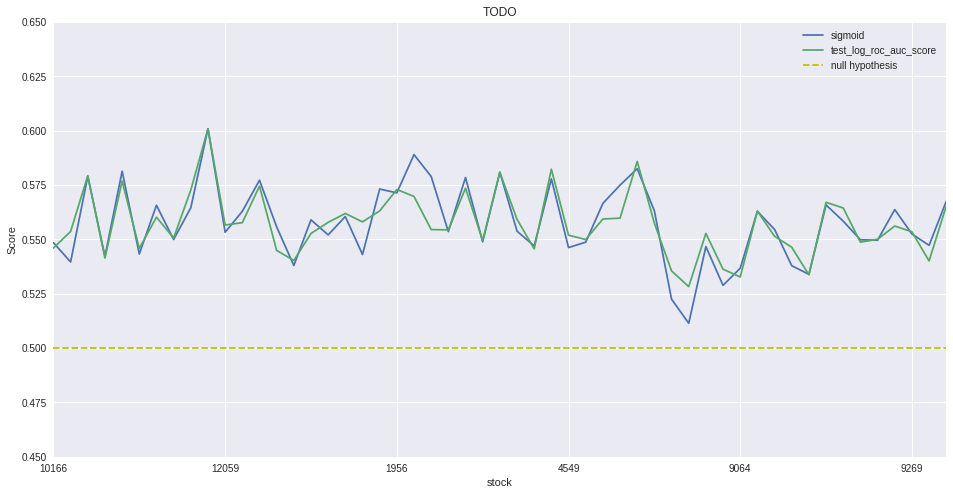

In [23]:
df_bests.sort_index(inplace=True)
df_kernels_test['sigmoid'].plot(figsize=(16,8))
df_bests['test_log_roc_auc_score'].plot()
plt.plot(np.zeros(len(df_kernels_test)) + 0.5, 'y--', label='null hypothesis')

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('TODO')

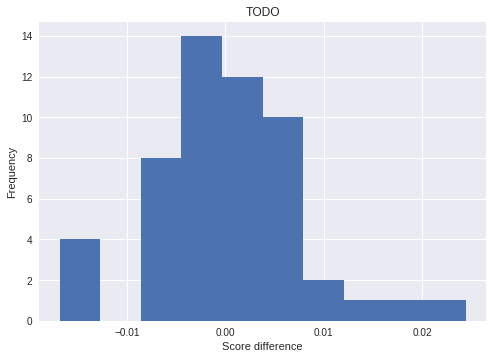

In [24]:
(df_kernels_test['sigmoid'] - df_bests['test_log_roc_auc_score']).plot(kind='hist')
plt.xlabel('Score difference')
plt.title('TODO')

## Best performing SVM kernels on testing set

For each stock and kernel we calculated results on testing set for the best choice of parameters from parameter tunning on validation set. Not always the best kernel is the one which performs the best on validation set (this means that either methodology is wrong or hyperparameter tunning could be improved or more data should be introduced, because some kernels don't generalize well). 

Especially **sigmoid** kernel does not seem to generalize well - **linear** kernel can be a better choice even if it performs worse on validation set.

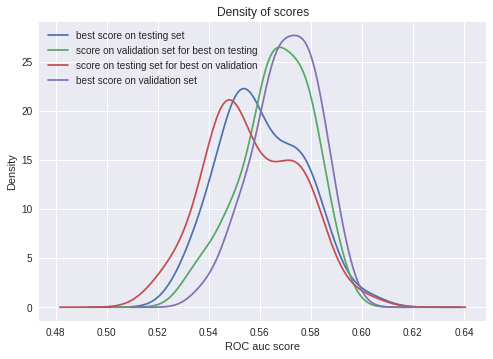

In [25]:
df_bests_by_test['test_roc_auc_score'].plot('kde', label='best score on testing set')
df_bests_by_test['roc_auc_score'].plot('kde', label='score on validation set for best on testing')
df_bests_by_val['test_roc_auc_score'].plot('kde', label='score on testing set for best on validation')
df_bests_by_val['roc_auc_score'].plot('kde', label='best score on validation set')

plt.title('Density of scores')
plt.xlabel('ROC auc score')
plt.legend()

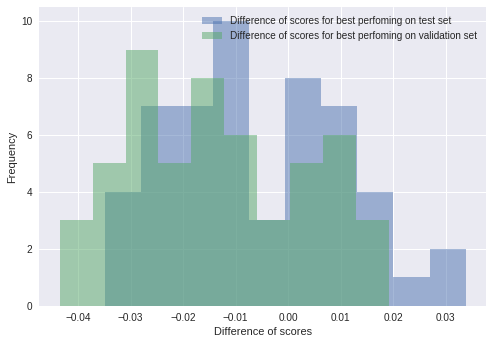

In [26]:
(df_bests_by_test['test_roc_auc_score'] - df_bests_by_test['roc_auc_score']).plot(
    'hist', alpha=0.5, label='Difference of scores for best perfoming on test set')
(df_bests_by_val['test_roc_auc_score'] - df_bests_by_val['roc_auc_score']).plot(
    'hist', alpha=0.5, label='Difference of scores for best perfoming on validation set')
plt.legend()
plt.xlabel('Difference of scores')

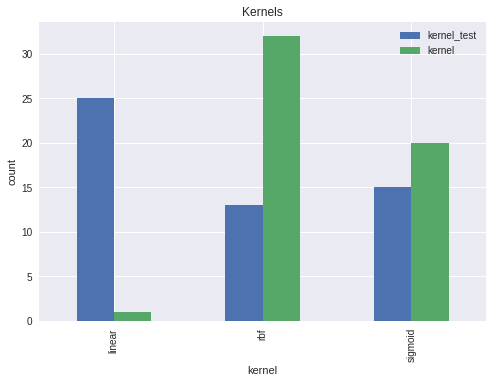

In [27]:
df_counts = df_bests_by_test.groupby(['kernel'])[['kernel']].count()
df_counts_val = df_bests_by_val.groupby(['kernel'])[['kernel']].count()
df_counts.rename(columns={'kernel': 'kernel_test'}, inplace=True)
df_counts = df_counts.join(df_counts_val)

df_counts.plot(kind='bar')
plt.title('Kernels')
plt.ylabel('count')
plt.xlabel('kernel')

### Best performing SVM kernels on testing set vs null hypothesis

We are always better than null hypothesis - we can have score better for about 0.5% on testing if we pick other type of kernel.

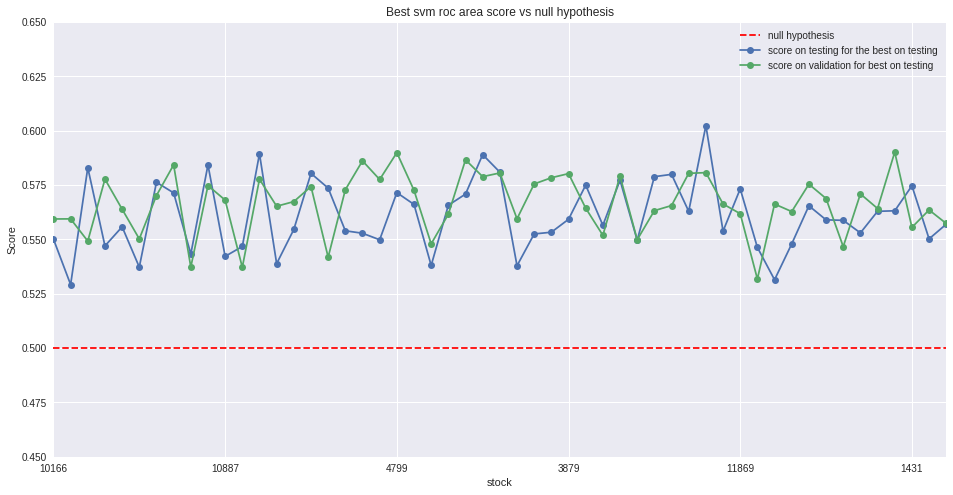

In [28]:
stocks = df_bests_by_val['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests_by_test['test_roc_auc_score'].plot(marker='o', label='score on testing for the best on testing', 
                                            figsize=(16, 8))
df_bests_by_test['roc_auc_score'].plot(marker='o', label='score on validation for best on testing')

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best svm roc area score vs null hypothesis')

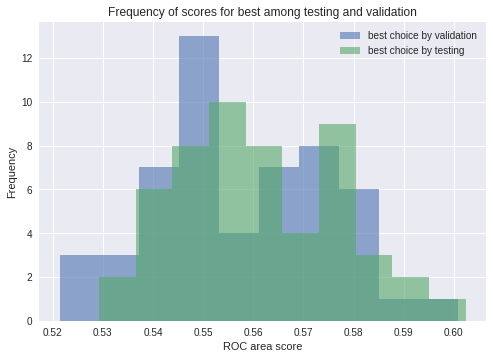

In [29]:
df_bests_by_val['test_roc_auc_score'].plot('hist', alpha=0.6, label='best choice by validation')
df_bests_by_test['test_roc_auc_score'].plot('hist', alpha=0.6, label='best choice by testing')
plt.legend()
plt.xlabel('ROC area score')
plt.title('Frequency of scores for best among testing and validation')

### Best perfoming SVM kernel on testing vs best perfoming on validation

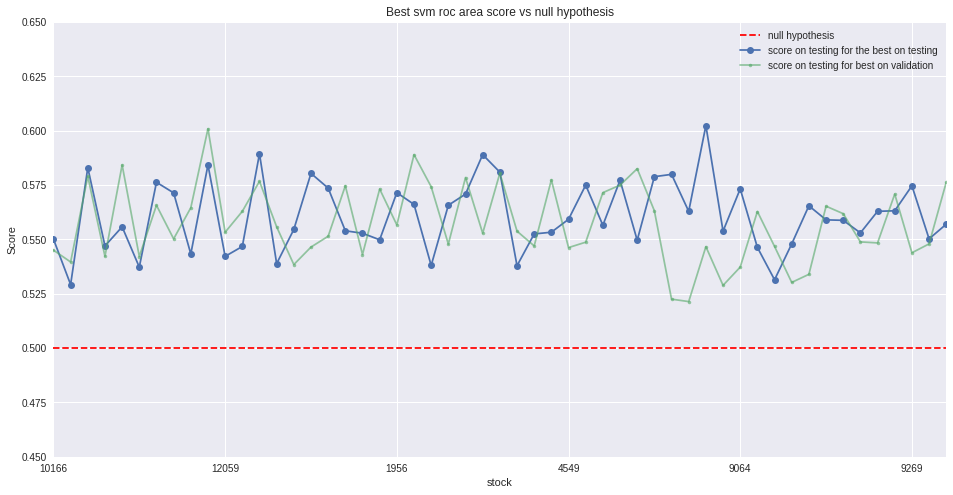

In [30]:
stocks = df_bests_by_val['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests_by_test['test_roc_auc_score'].plot(marker='o', label='score on testing for the best on testing', 
                                            figsize=(16, 8))

df_bests_by_val['test_roc_auc_score'].plot(marker='.', label='score on testing for best on validation', 
                                           alpha=0.6)

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best svm roc area score vs null hypothesis')

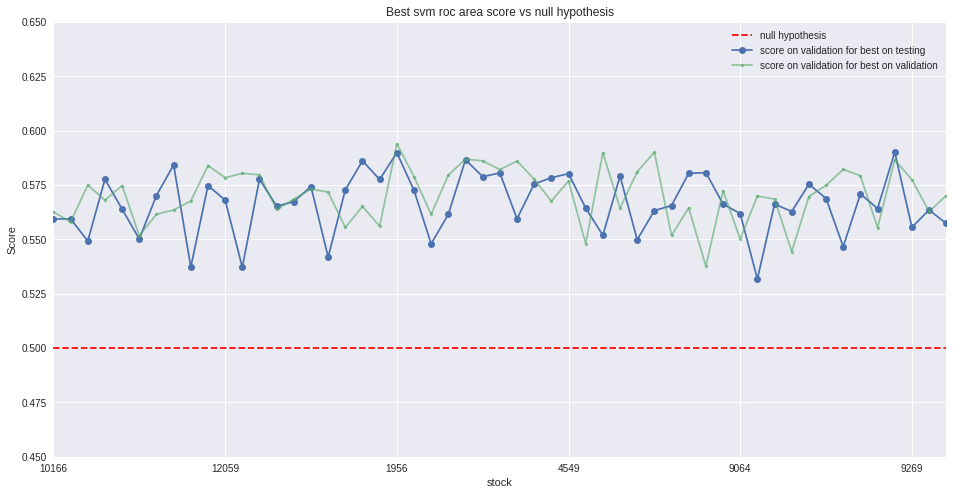

In [31]:
stocks = df_bests_by_val['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')

df_bests_by_test['roc_auc_score'].plot(marker='o', label='score on validation for best on testing', figsize=(16,8))
df_bests_by_val['roc_auc_score'].plot(marker='.', label='score on validation for best on validation', 
                                      alpha=0.6)
plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.65)
plt.title('Best svm roc area score vs null hypothesis')

#### Best perfoming SVM kernel on testing set vs logistic regression

In [32]:
print('Number of better SVMs:', 
      len(df_bests_by_test[df_bests_by_test['test_log_roc_auc_score'] < 
                           df_bests_by_test['test_roc_auc_score']]['stock'].unique()), 
      'per', len(df_bests_by_test['stock'].unique()))

Number of better SVMs: 36 per 53


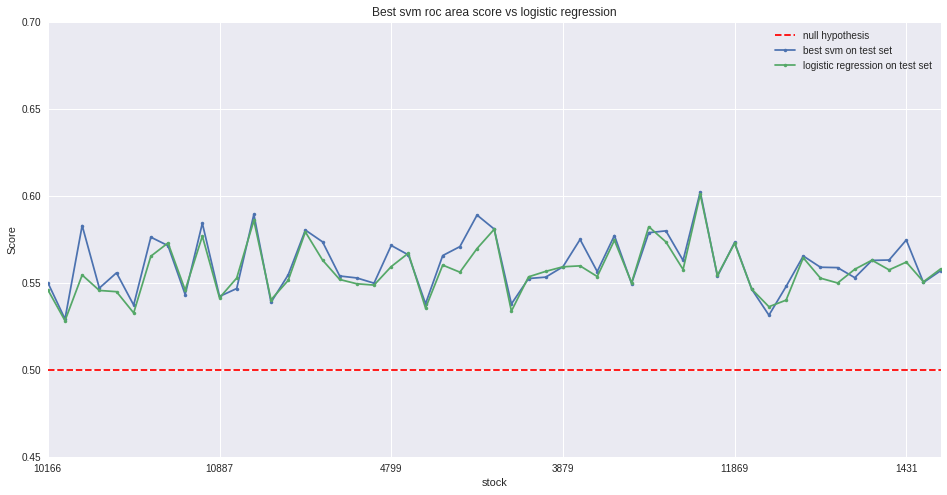

In [33]:
stocks = df_bests_by_test['stock'].values
plt.plot(np.zeros(len(stocks)) + 0.5, 'r--', label='null hypothesis')
df_bests_by_test['test_roc_auc_score'].plot(marker='.', label='best svm on test set', figsize=(16,8))
df_bests_by_test['test_log_roc_auc_score'].plot(marker='.', label='logistic regression on test set')

plt.ylabel('Score')
plt.legend()
plt.ylim(0.45, 0.7)
plt.title('Best svm roc area score vs logistic regression')

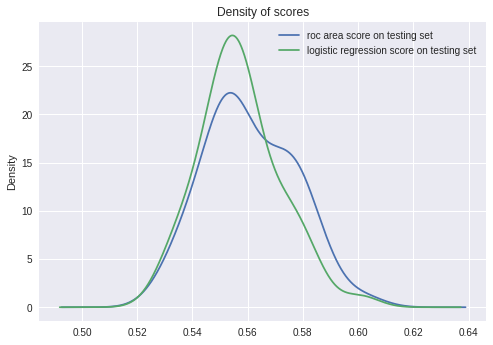

In [34]:
df_bests_by_test['test_roc_auc_score'].plot('kde', label='roc area score on testing set')
df_bests_by_test['test_log_roc_auc_score'].plot('kde', label='logistic regression score on testing set')
plt.title('Density of scores')
plt.legend()

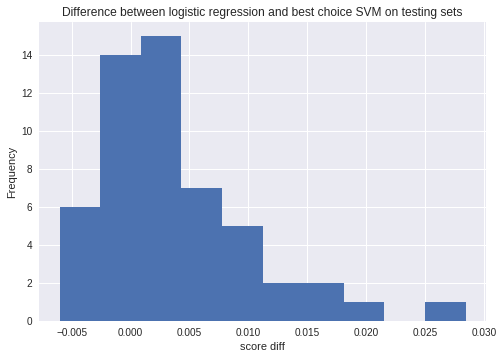

In [35]:
df_bests_by_test['diff'].plot(kind='hist')
plt.title('Difference between logistic regression and best choice SVM on testing sets')
plt.xlabel('score diff')

In [36]:
## Metric mean_bid_ask_len

In [37]:
def add_mean_bid_ask(df, dfs):
    mean_bid_ask_len = []
    for s in df.index:
        sum_len_bid_ask = 0
        sum_len_bid = 0
        sum_len_ask = 0
        for i, row in dfs[s].iterrows():
            sum_len_bid_ask += (len(row['ask']) + len(row['bid']))
            sum_len_bid += len(row['bid'])
            sum_len_ask += len(row['ask'])
        mean_bid_ask_len.append(sum_len_bid_ask / (2 * len(dfs[s])))
    df['mean_bid_ask_len'] = mean_bid_ask_len
    
def prepare_summary(df_summary, stocks, dfs):
    sum_sell_ask_mean = []
    sum_buy_bid_mean = []
    max_trade_price = []
    min_trade_price = []
    bid_ask_spread = []
    bid_len = []
    ask_len = []
    mean_bid_ask_len = []
    mean_bid_len = []
    mean_ask_len = []

    for s in stocks:
        sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
        sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
        max_trade_price.append(max(dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
        min_trade_price.append(max(dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
        bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())

        max_len_bid = 0
        max_len_ask = 0

        for i, row in dfs[s].iterrows():
            if len(row['bid']) > max_len_bid:
                max_len_bid = len(row['bid'])
            if len(row['ask']) > max_len_ask:
                max_len_ask = len(row['ask'])
        bid_len.append(max_len_bid)
        ask_len.append(max_len_ask)

        sum_len_bid_ask = 0
        sum_len_bid = 0
        sum_len_ask = 0
        for i, row in dfs[s].iterrows():
            sum_len_bid_ask += (len(row['ask']) + len(row['bid']))
            sum_len_bid += len(row['bid'])
            sum_len_ask += len(row['ask'])
        mean_bid_ask_len.append(sum_len_bid_ask / (2 * len(dfs[s])))
        mean_bid_len.append(sum_len_bid / len(dfs[s]))
        mean_ask_len.append(sum_len_ask / len(dfs[s]))
    df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
    df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
    df_summary['max_trade_price'] = max_trade_price
    df_summary['min_trade_price'] = min_trade_price
    df_summary['bid_ask_spread'] = bid_ask_spread
    df_summary['max_len_ask'] = ask_len
    df_summary['max_len_bid'] = bid_len
    df_summary['mean_bid_ask_len'] = mean_bid_ask_len
    df_summary['mean_bid_len'] = mean_bid_len
    df_summary['mean_ask_len'] = mean_ask_len
    return df_summary


In [38]:
dfs = {}
dfs_test = {}
dfs_cv = {}

stocks = df_bests_by_test.index

for s in stocks:
    d, d_cv, d_test = lob.load_prepared_data(s, data_dir='../data/prepared/', cv=True, length=data_length)
    dfs[s] = d
    dfs_test[s] = d_test

In [39]:
prepare_summary(df_bests_by_test, stocks, dfs)

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score,test_log_roc_auc_score,diff,sum_sell_ask_mean,sum_buy_bid_mean,max_trade_price,min_trade_price,bid_ask_spread,max_len_ask,max_len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len
stock,,,,,,,,,,,,,,,,,,,,
10166,0.500,0.000,cv,-1.000,linear,0.559372,10166,0.550122,0.546020,4.101804e-03,800.550333,860.828500,3454.50,2968.50,1.195917,1222,1446,911.517583,992.135167,830.900000
9061,0.005,0.000,cv,-1.000,linear,0.559418,9061,0.529202,0.528266,9.360599e-04,6036.664000,6484.967833,730.20,662.60,0.186950,2271,1785,1513.455583,1320.312667,1706.598500
2651,500.000,0.000,cv,-1.000,linear,0.549207,2651,0.582952,0.554502,2.844977e-02,3410.019167,3526.256167,535.00,463.10,0.296683,1107,1115,747.376667,763.664500,731.088833
4060,5.000,0.000,cv,5.000,rbf,0.577680,4060,0.546979,0.545629,1.350844e-03,4062.935333,4430.731167,378.00,336.40,0.242717,1034,888,629.305833,613.310000,645.301667
12456,500.000,0.500,cv,0.005,sigmoid,0.563869,12456,0.555760,0.544916,1.084428e-02,754.949833,751.345833,3735.00,3061.00,2.027667,860,671,478.209250,455.373833,501.044667
9064,500.000,0.000,cv,50.000,rbf,0.550204,9064,0.537237,0.532707,4.530610e-03,29310.552500,30483.127833,79.85,73.21,0.025982,2204,1813,1426.368417,1371.680333,1481.056500
9761,0.500,0.000,cv,500.000,rbf,0.570171,9761,0.576253,0.565315,1.093835e-02,4796.842667,4636.940500,1058.00,943.50,0.961833,1121,1044,614.804000,605.613000,623.995000
1956,0.500,0.005,cv,0.005,sigmoid,0.584267,1956,0.571381,0.572923,-1.542025e-03,7440.167167,8133.749667,306.40,273.40,0.153583,1040,846,681.739667,643.860333,719.619000
11244,500.000,0.500,cv,0.005,sigmoid,0.537240,11244,0.543280,0.545852,-2.571912e-03,4272.275500,4640.869667,355.50,325.00,0.113042,3016,2584,2252.087500,2027.308500,2476.866500


In [40]:
df_bests_by_test.head()

,c,coef0,data_type,gamma,kernel,roc_auc_score,stock,test_roc_auc_score,test_log_roc_auc_score,diff,sum_sell_ask_mean,sum_buy_bid_mean,max_trade_price,min_trade_price,bid_ask_spread,max_len_ask,max_len_bid,mean_bid_ask_len,mean_bid_len,mean_ask_len
stock,,,,,,,,,,,,,,,,,,,,
10166,0.500,0.0,cv,-1.000,linear,0.559372,10166,0.550122,0.546020,0.004102,800.550333,860.828500,3454.5,2968.5,1.195917,1222,1446,911.517583,992.135167,830.900000
9061,0.005,0.0,cv,-1.000,linear,0.559418,9061,0.529202,0.528266,0.000936,6036.664000,6484.967833,730.2,662.6,0.186950,2271,1785,1513.455583,1320.312667,1706.598500
2651,500.000,0.0,cv,-1.000,linear,0.549207,2651,0.582952,0.554502,0.028450,3410.019167,3526.256167,535.0,463.1,0.296683,1107,1115,747.376667,763.664500,731.088833
4060,5.000,0.0,cv,5.000,rbf,0.577680,4060,0.546979,0.545629,0.001351,4062.935333,4430.731167,378.0,336.4,0.242717,1034,888,629.305833,613.310000,645.301667
12456,500.000,0.5,cv,0.005,sigmoid,0.563869,12456,0.555760,0.544916,0.010844,754.949833,751.345833,3735.0,3061.0,2.027667,860,671,478.209250,455.373833,501.044667


In [41]:
kernel_names = {"linear": 0, 'sigmoid': 2, "rbf": 1}
df_bests_by_test['kernel_class'] = [kernel_names.get(n) for n in df_bests_by_test['kernel'].values]

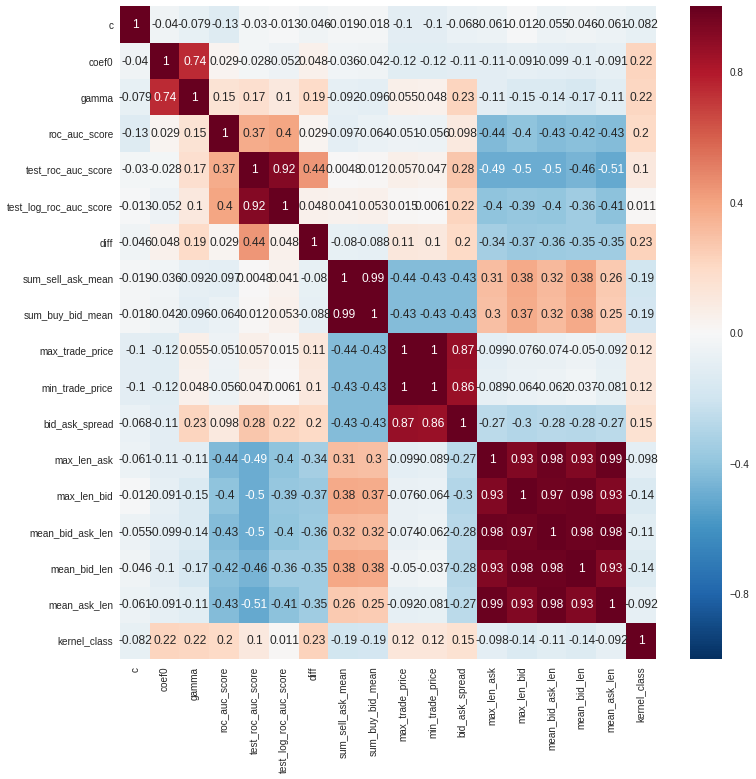

In [44]:
plt.figure(figsize=(12, 12))
sns.heatmap(df_bests_by_test.corr(), annot=True)

In [43]:
df_bests_by_test[['kernel_class', 'mean_bid_ask_len']].sort_values(by='mean_bid_ask_len')

,kernel_class,mean_bid_ask_len
stock,,
11869,0,399.933333
12417,2,411.356917
1431,1,414.739417
12255,2,452.682750
4549,0,454.126167
11946,0,465.986750
10484,0,467.213917
12456,2,478.209250
3035,1,518.150667
